## Starter Notebook For The Côte d’Ivoire Byte-Sized Agriculture Challenge

This starter notebook achieves the following:


1.   Load & display satellite images
2.   Build a basic machine learning model
3.   Prepare the predictions for submission.

The machine learning model shown here is by no mean ideal. Winning models should leverage multi-temporal data and not single-date imagery.

# Processing  the GTIFF files

Here's a complete list of **Sentinel-2 bands** along with their **descriptions**, **wavelengths**, and **spatial resolutions**:

---

### 🛰️ **Sentinel-2 Band Overview**

| Band | Name                    | Wavelength (nm) | Resolution (m) | Description |
|------|-------------------------|-----------------|----------------|-------------|
| B1   | Coastal aerosol         | 443             | 60             | Useful for atmospheric correction and aerosol detection. |
| B2   | Blue                    | 490             | 10             | Penetrates water; used for vegetation, water bodies, and coastal mapping. |
| B3   | Green                   | 560             | 10             | Good for assessing plant health and measuring biomass. |
| B4   | Red                     | 665             | 10             | Key band for vegetation discrimination and chlorophyll absorption. |
| B5   | Red Edge 1              | 705             | 20             | Useful for detecting subtle changes in vegetation. |
| B6   | Red Edge 2              | 740             | 20             | Further detail on vegetation, especially stress and growth stages. |
| B7   | Red Edge 3              | 783             | 20             | Extended vegetation monitoring. |
| B8   | NIR (Near Infrared)     | 842             | 10             | Excellent for vegetation vigor, biomass, and land-water contrast. |
| B8A  | Narrow NIR (Red Edge 4) | 865             | 20             | Sensitive to chlorophyll content and canopy structure. |
| B9   | Water Vapor             | 945             | 60             | Atmospheric correction (water vapor absorption). |
| B10  | SWIR – Cirrus           | 1375            | 60             | Detects high-altitude clouds (cirrus); not used for land analysis. |
| B11  | SWIR 1                  | 1610            | 20             | Differentiates clouds, snow, and vegetation moisture. |
| B12  | SWIR 2                  | 2190            | 20             | Useful for geology, soil, and burnt area mapping. |

---

### ✅ Band Groupings by Application

#### **RGB (Natural Color)**
- **B4 (Red)**
- **B3 (Green)**
- **B2 (Blue)**

#### **Vegetation Indices**
- **NDVI:** B8 (NIR) & B4 (Red)
- **EVI:** B8 (NIR), B4 (Red), B2 (Blue)
- **SAVI:** B8 (NIR) & B4 (Red)
- **NDRE:** B8A (Narrow NIR) & B5 (Red Edge)

#### **Cloud/Atmosphere Analysis**
- B1, B9, B10

#### **Snow/Ice Monitoring**
- B3, B11, B12

---


In [1]:
%%capture
!pip install rasterio -q

In [2]:

import os
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import gc

In [12]:

DATA_PATH = Path.cwd() 
TRAIN_IMAGES_PATH = DATA_PATH / 'S2Images' / 'train'
TEST_IMAGES_PATH = DATA_PATH / 'S2Images' / 'test'
TRAIN_CSV_PATH = DATA_PATH / "TrainDataset.csv"
TEST_CSV_PATH = DATA_PATH / "TestDataset.csv"
subPath = DATA_PATH / "CNNsubmission.csv"

In [13]:

## Utility function - count the number of files in a folder:

def count_all_files(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

In [14]:

folder_path = TRAIN_IMAGES_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in 'c:\Users\jkneisly\Documents\Georgia Tech\CS 7643 - Deep Learning\Project\Data\S2Images\train': 7433


In [15]:

folder_path = TEST_IMAGES_PATH
total_files = count_all_files(folder_path)

print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in 'c:\Users\jkneisly\Documents\Georgia Tech\CS 7643 - Deep Learning\Project\Data\S2Images\test': 2201


In [16]:

## Load the train/test csv files
train = pd.read_csv(TRAIN_CSV_PATH)
test = pd.read_csv(TEST_CSV_PATH)

# drop rows with empty tifPath
train = train.dropna(subset=['tifPath'])
test = test.dropna(subset=['tifPath'])

In [17]:

train.head()

ID  year month  \
0  ID_h14T0B_Jan  2024   Jan   
1  ID_KbyKOr_Jan  2024   Jan   
2  ID_t4Tmmn_Jan  2024   Jan   
3  ID_yipWoC_Jan  2024   Jan   
4  ID_XKiksa_Jan  2024   Jan   

                                             tifPath  Target  class  
0  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  Rubber      3  
1  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  Rubber      3  
2  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  Rubber      3  
3  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  Rubber      3  
4  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  Rubber      3

In [18]:

test.head()

ID  year month  \
0  ID_731818_Jan  2024   Jan   
1  ID_790093_Jan  2024   Jan   
2  ID_931033_Jan  2024   Jan   
3  ID_079024_Jan  2024   Jan   
4  ID_691532_Jan  2024   Jan   

                                             tifPath  
0  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  
1  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  
2  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  
3  /Users/jkneisly/Documents/Georgia Tech/CS 7643...  
4  /Users/jkneisly/Documents/Georgia Tech/CS 7643...

In [19]:

train_tiffs = [Path(tifPath) for tifPath in train.tifPath.values if str(tifPath).endswith(".tif")]
len(train_tiffs)

7433

In [20]:

test_tiffs = [Path(tifPath) for tifPath in test.tifPath.values if str(tifPath).endswith(".tif")]
len(test_tiffs)

2201

In [21]:

## Check the size of each of these tifs

def print_tif_sizes(tif_files):
    """
    Prints the size of each TIFF file in MB and GB.

    Parameters:
        tif_files (list): List of TIFF file names (str).
    """
    for file_path in tif_files:

        # Get the size in bytes
        tif_size_bytes = os.path.getsize(file_path)

        # Convert bytes to MB and GB
        tif_size_kb = tif_size_bytes / 1024
        tif_size_mb = tif_size_bytes / (1024 * 1024)
        tif_size_gb = tif_size_bytes / (1024 * 1024 * 1024)

        # Print sizes
        print(f"{file_path.name} size: {tif_size_kb:.2f} KB")
        #print(f"{file_path.name} size: {tif_size_mb:.2f} MB")
        #print(f"{file_path.name} size: {tif_size_gb:.2f} GB")

In [22]:

## Check size of train files
print_tif_sizes(train_tiffs[:10])

s2_Rubber_ID_h14T0B_2024_01.tif size: 53.27 KB
s2_Rubber_ID_KbyKOr_2024_01.tif size: 54.37 KB
s2_Rubber_ID_t4Tmmn_2024_01.tif size: 56.38 KB
s2_Rubber_ID_yipWoC_2024_01.tif size: 55.25 KB
s2_Rubber_ID_XKiksa_2024_01.tif size: 56.55 KB
s2_Rubber_ID_zNx6qQ_2024_01.tif size: 54.95 KB
s2_Palm_ID_KfCbOO_2024_01.tif size: 97.40 KB
s2_Palm_ID_ZUfp59_2024_01.tif size: 59.64 KB
s2_Palm_ID_DdAycp_2024_01.tif size: 60.75 KB
s2_Rubber_ID_X9dg4u_2024_01.tif size: 54.03 KB


In [23]:

## Check size of test files
print_tif_sizes(test_tiffs[:10])

s2_Unknown_ID_731818_2024_01.tif size: 62.65 KB
s2_Unknown_ID_790093_2024_01.tif size: 61.45 KB
s2_Unknown_ID_931033_2024_01.tif size: 61.45 KB
s2_Unknown_ID_079024_2024_01.tif size: 61.45 KB
s2_Unknown_ID_691532_2024_01.tif size: 61.45 KB
s2_Unknown_ID_094903_2024_01.tif size: 61.45 KB
s2_Unknown_ID_601980_2024_01.tif size: 61.45 KB
s2_Unknown_ID_766365_2024_01.tif size: 61.45 KB
s2_Unknown_ID_406501_2024_01.tif size: 61.45 KB
s2_Unknown_ID_237616_2024_01.tif size: 62.65 KB


In [24]:

import rasterio

def get_tif_metadata(tif_path):
    """
    Retrieves and prints metadata for a given TIFF file.

    Parameters:
    - tif_path (str or Path): Path to the TIFF file.

    This function opens the TIFF file, retrieves its dimensions (width, height),
    and the number of bands, then prints the relevant metadata.
    """
    with rasterio.open(tif_path) as src:
        # Get the image width (number of columns)
        width = src.width

        # Get the image height (number of rows)
        height = src.height

        # Get the number of bands in the image (e.g., RGB bands or multispectral bands)
        count = src.count

        # Print image dimensions (width x height) and the number of bands
        print(f"Image Name: {tif_path.name}")
        print(f"Image Dimensions: {width}x{height} pixels")
        print(f"Number of Bands: {count}\n")


## Get Metadata Information

In [25]:

## Get meta data information for each train tiff
for train_tif in train_tiffs[:10]:
  get_tif_metadata(train_tif)

Image Name: s2_Rubber_ID_h14T0B_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_KbyKOr_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_t4Tmmn_2024_01.tif
Image Dimensions: 52x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_yipWoC_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_XKiksa_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_zNx6qQ_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Palm_ID_KfCbOO_2024_01.tif
Image Dimensions: 71x59 pixels
Number of Bands: 12

Image Name: s2_Palm_ID_ZUfp59_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Palm_ID_DdAycp_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Rubber_ID_X9dg4u_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12



In [26]:

## Get meta data for test tiffs
for test_tif in test_tiffs[:10]:
  get_tif_metadata(test_tif)

Image Name: s2_Unknown_ID_731818_2024_01.tif
Image Dimensions: 51x52 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_790093_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_931033_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_079024_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_691532_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_094903_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_601980_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_766365_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_406501_2024_01.tif
Image Dimensions: 51x51 pixels
Number of Bands: 12

Image Name: s2_Unknown_ID_237616_2024_01.tif
Image Dimensions: 51x52 pixels
Number of Bands: 12



In [27]:

def get_min_max_tile_size(tif_paths):
    """
    Calculate both the minimum and maximum tile sizes (height × width) from a list of .tif file paths.

    Parameters:
    - tif_paths (list of str or Path): List of paths to .tif files

    Returns:
    - min_result (tuple): (min_size, shape, file_path, index)
    - max_result (tuple): (max_size, shape, file_path, index)
    """
    min_size = float('inf')
    max_size = 0
    min_shape = max_shape = (0, 0)
    min_file = max_file = None
    min_idx = max_idx = None

    for idx, path in enumerate(tif_paths):
        with rasterio.open(path) as src:
            height, width = src.height, src.width
            size = height * width

            if size < min_size:
                min_size = size
                min_shape = (height, width)
                min_file = path
                min_idx = idx

            if size > max_size:
                max_size = size
                max_shape = (height, width)
                max_file = path
                max_idx = idx

    min_result = (min_size, min_shape, str(min_file), min_idx)
    max_result = (max_size, max_shape, str(max_file), max_idx)
    return min_result, max_result

In [60]:
# Get min/max tile size of train
min_train_results, max_train_results = get_min_max_tile_size(train_tiffs)

# Get min/max tile size of test
min_test_results, max_test_results = get_min_max_tile_size(test_tiffs)

# Overall max_tile_size
max_tile_height = max(max_train_results[1][0], max_test_results[1][0])
max_tile_width = max(max_train_results[1][1], max_test_results[1][1])

# Overall min_tile_size
min_tile_height = min(min_train_results[1][0], min_test_results[1][0])
min_tile_width = min(min_train_results[1][1], min_test_results[1][1])

# Assume a square tile
MAX_TILE_SIZE = max(max_tile_height, max_tile_width)
MIN_TILE_SIZE = min(min_tile_height, min_tile_width)

max_train_idx = max_train_results[3]
max_test_idx = max_test_results[3]

min_train_idx = min_train_results[3]
min_test_idx = min_test_results[3]

max_train_tif_shape = max_train_results[1]
max_test_tif_shape = max_test_results[1]

min_train_tif_shape = min_train_results[1]
min_test_tif_shape = min_test_results[1]

max_train_tif_file = max_train_results[2]
min_train_tif_file = min_train_results[2]

max_test_tif_file = max_test_results[2]
min_test_tif_file = min_test_results[2]

In [61]:

print(f"The maximum tile size for train is at {max_train_idx} with: (height x width) = {max_train_tif_shape}.")
print(f"The raster image from train with maximum dimension is:\n\t{max_train_tif_file}.\n")
print(f"The minimum tile size for train is at {min_train_idx}: (height x width) = {min_train_tif_shape}.")
print(f"The raster image from train with the minimum dimension is:\n\t{min_train_tif_file}.\n")

print(f"The maximum tile size for test is at {max_test_idx} with : (height x width) = {max_test_tif_shape}.")
print(f"The raster image from test with maximum dimension is:\n\t{max_test_tif_file}.\n")
print(f"The minimum tile size for test is at {min_test_idx}: (height x width) = {min_test_tif_shape}.")
print(f"The raster image from test with the minimum dimension is:\n\t{min_test_tif_file}.")

print(f"\nThe maximum tile size to use: MAX_TILE_SIZE = {(MAX_TILE_SIZE, MAX_TILE_SIZE)}.")

The maximum tile size for train is at 552 with: (height x width) = (236, 237).
The raster image from train with maximum dimension is:
	\Users\jkneisly\Documents\Georgia Tech\CS 7643 - Deep Learning\Project\Data\S2Images\train\s2_Cocoa_ID_MVbwcd_2024_01.tif.

The minimum tile size for train is at 0: (height x width) = (51, 51).
The raster image from train with the minimum dimension is:
	\Users\jkneisly\Documents\Georgia Tech\CS 7643 - Deep Learning\Project\Data\S2Images\train\s2_Rubber_ID_h14T0B_2024_01.tif.

The maximum tile size for test is at 192 with : (height x width) = (245, 326).
The raster image from test with maximum dimension is:
	\Users\jkneisly\Documents\Georgia Tech\CS 7643 - Deep Learning\Project\Data\S2Images\test\s2_Unknown_ID_615930_2024_01.tif.

The minimum tile size for test is at 1: (height x width) = (51, 51).
The raster image from test with the minimum dimension is:
	\Users\jkneisly\Documents\Georgia Tech\CS 7643 - Deep Learning\Project\Data\S2Images\test\s2_Unknow

## Visualisation Functions

In [62]:

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window

## These functions assumes that the 6 bands downloaded are
## ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


def process_window(tif_path, window=None):
    """
    Reads a window or full data from a GeoTIFF and handles NoData values.
    """
    with rasterio.open(tif_path) as src:
        if window is not None:
            data = src.read(window=window)
        else:
            data = src.read()

        nodata_value = src.nodata
        if nodata_value is not None:
            data = np.ma.masked_equal(data, nodata_value)

    return data

def normalize_band(band):
    """
    Normalizes a band to the [0, 1] range, safely handling NaN/masked values.
    """
    band = np.ma.masked_invalid(band)
    band_min = band.min()
    band_max = band.max()

    if band_max > band_min:
        return (band - band_min) / (band_max - band_min)
    else:
        return band  # Return unchanged if no variation

## ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

def plot_rgb_window(tif_path, window=None, r_band_idx=3, g_band_idx=2, b_band_idx=1):
    """
    Plots an RGB composite image from the specified bands.
    """
    data = process_window(tif_path, window)

    red = normalize_band(data[r_band_idx, :, :])
    green = normalize_band(data[g_band_idx, :, :])
    blue = normalize_band(data[b_band_idx, :, :])

    rgb = np.stack([red, green, blue], axis=-1)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.title(f"RGB Composite")
    plt.axis("off")
    plt.show()

def plot_single_band(tif_path, window=None, band_idx=0, cmap='gray'):
    """
    Plots a single band from the GeoTIFF.
    """
    data = process_window(tif_path, window)
    band_normalized = normalize_band(data[band_idx, :, :])

    plt.figure(figsize=(8, 8))
    plt.imshow(band_normalized, cmap=cmap)
    plt.title(f"Band {band_idx}")
    plt.axis("off")
    plt.show()

def plot_vegetation_index(tif_path, window=None, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn'):
    """
    Plots NDVI using the given Red and NIR band indices.
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    nir = data[nir_band_idx, :, :]
    ndvi = (nir - red) / (nir + red)

    plt.figure(figsize=(8, 8))
    plt.imshow(ndvi, cmap=cmap)
    plt.title(f"Vegetation Index (NDVI)")
    plt.axis("off")
    plt.show()

def plot_evi(tif_path, window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral'):
    """
    Plots EVI using Red, Blue, and NIR band indices.
    Alternative cmaps 'coolwarm', 'PiYG', 'viridis'
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    blue = data[blue_band_idx, :, :]
    nir = data[nir_band_idx, :, :]

    L = 10000

    evi = 2.5 * ((nir - red) / (nir + 6*red - 7.5*blue + L))

    plt.figure(figsize=(8, 8))
    plt.imshow(evi, cmap=cmap)
    plt.title(f"Enhanced Vegetation Index (EVI) - Window: {window}")
    plt.axis("off")
    plt.show()


def plot_savi(tif_path, window=None, red_band_idx=3, nir_band_idx=7, L=0.5, cmap='YlGn'):
    """
    Plots SAVI using Red and NIR bands with a soil brightness correction factor.
    """
    data = process_window(tif_path, window)
    red = data[red_band_idx, :, :]
    nir = data[nir_band_idx, :, :]

    savi = ((nir - red) / (nir + red + L)) * (1 + L)

    plt.figure(figsize=(8, 8))
    plt.imshow(savi, cmap=cmap)
    plt.title(f"Soil Adjusted Vegetation Index (SAVI)")
    plt.axis("off")
    plt.show()


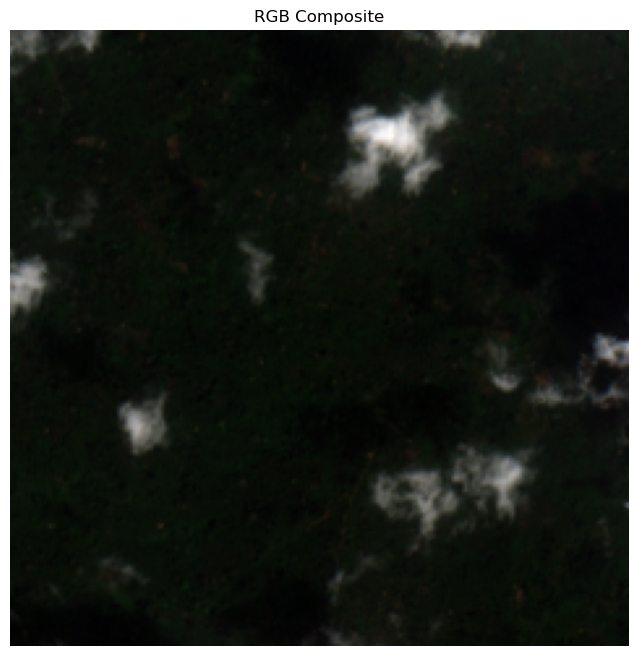

In [63]:

window = None #Window(0, 0, 1024, 1024)
# Plot RGB image (Red: band 2, Green: band 1, Blue: band 0)
plot_rgb_window(train_tiffs[max_train_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

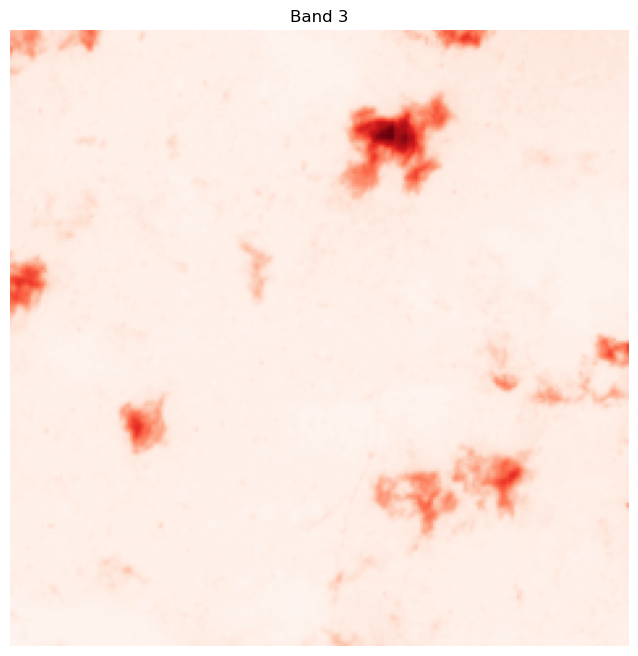

In [64]:

# Plot a single band (e.g., Red band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=3, cmap='Reds')

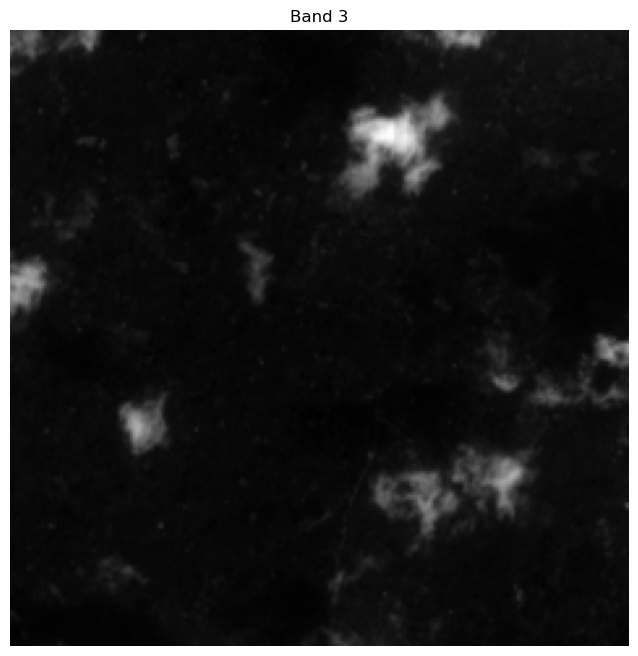

In [65]:

# Plot a single band (e.g., Red band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=3, cmap='gray')

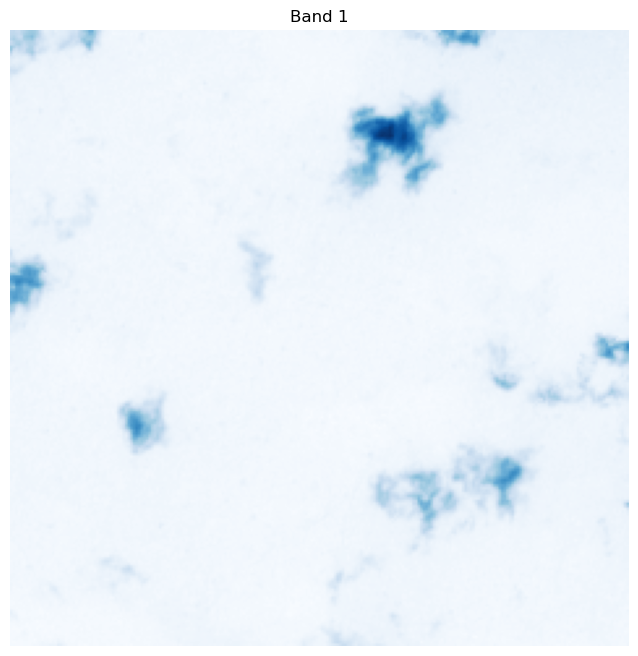

In [66]:

# Plot a single band (e.g., Blue band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=1, cmap='Blues')

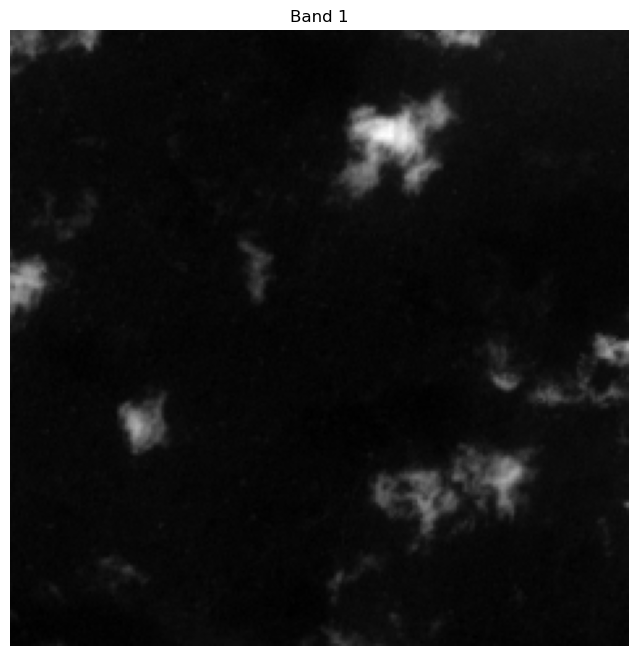

In [67]:

# Plot a single band (e.g., Blue band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=1, cmap='gray')

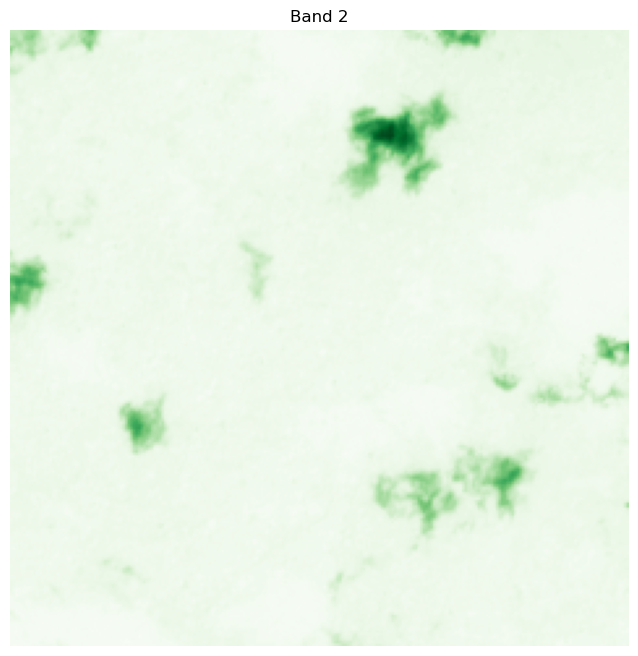

In [68]:

# Plot a single band (e.g., Green band)
plot_single_band(train_tiffs[max_train_idx], window, band_idx=2, cmap='Greens')

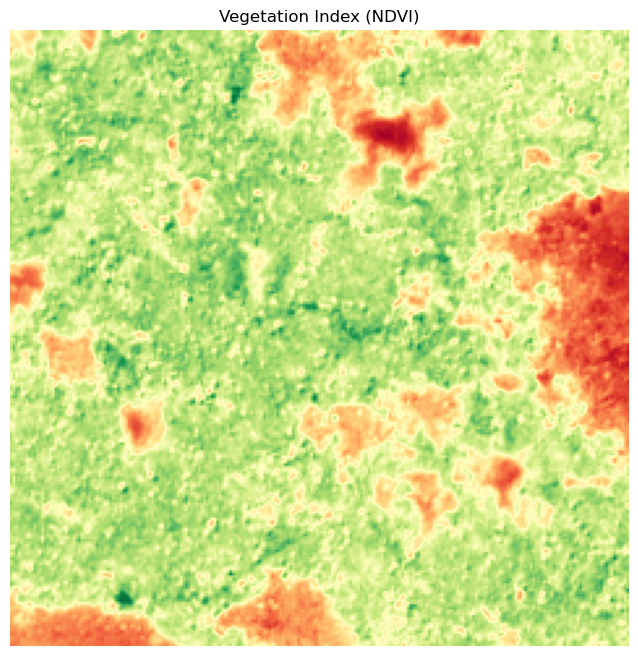

In [69]:

# Plot Vegetation Index (NDVI)
# cmap: 'viridis', 'BrBG', 'YlGn', 'PiYG', 'RdYlGn'
plot_vegetation_index(train_tiffs[max_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

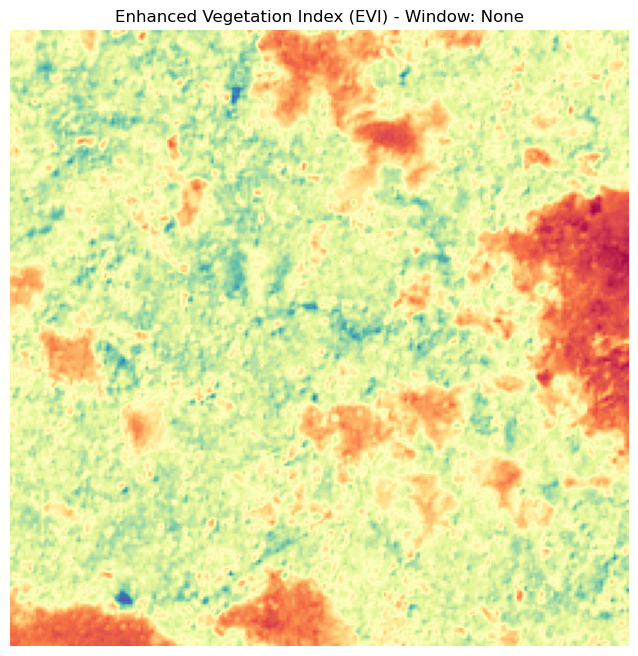

In [70]:

# Plot Enhanced Vegetation Index (EVI)
# cmap: 'coolwarm', 'PiYG', 'viridis', 'Spectral'
plot_evi(train_tiffs[max_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

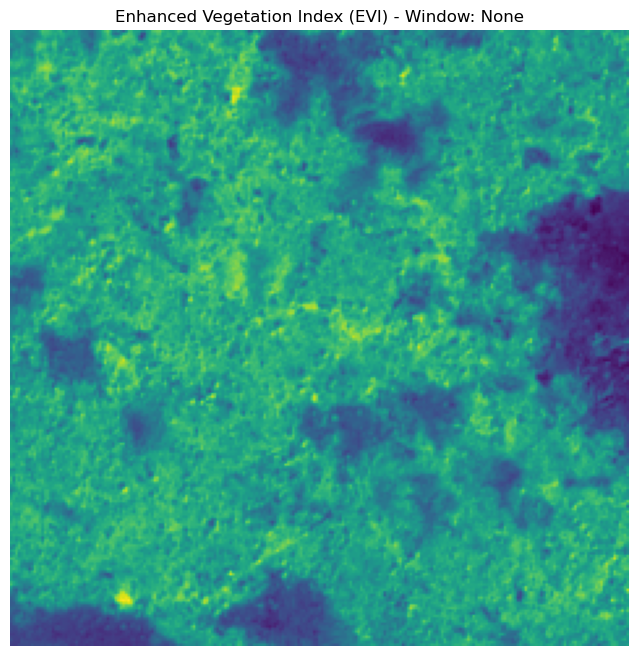

In [71]:


plot_evi(train_tiffs[max_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='viridis')

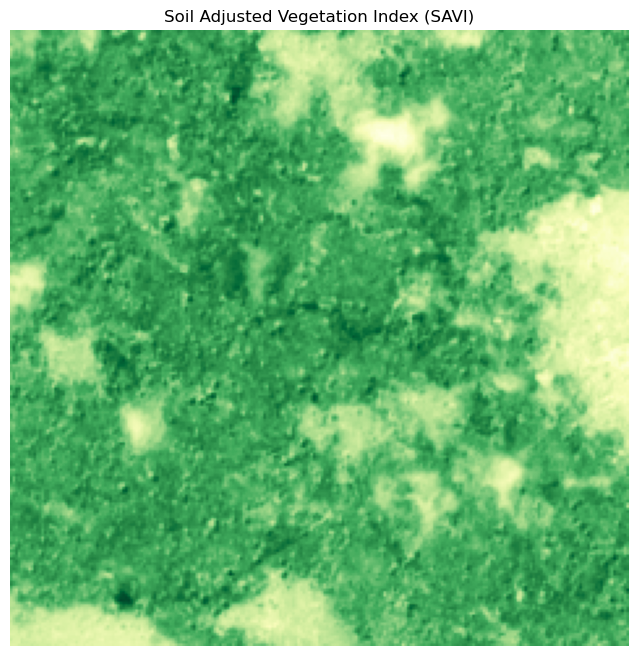

In [72]:

# Plot Soil Adjusted Vegetation Index (SAVI)
# cmap 'Greens', 'YlGnBu', 'YlGn'
plot_savi(train_tiffs[max_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

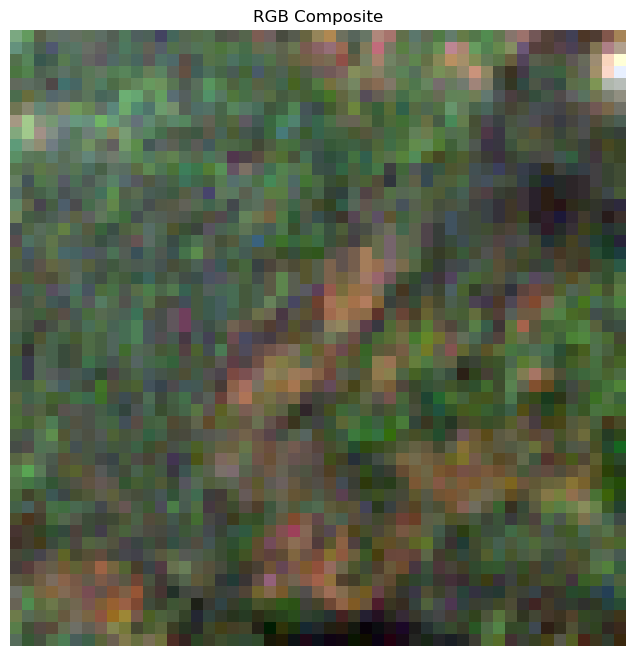

In [73]:

# Plot RGB image (Red: band 2, Green: band 1, Blue: band 0)
plot_rgb_window(train_tiffs[min_train_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

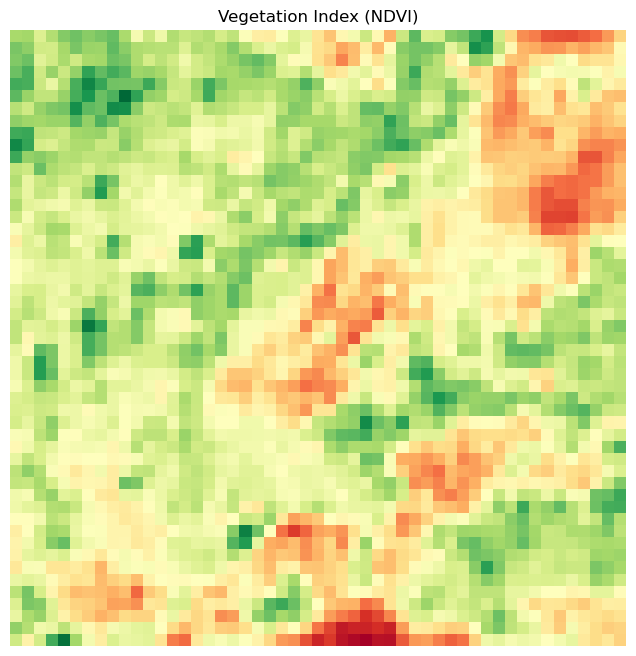

In [74]:

# Plot Vegetation Index (NDVI)
# cmap: 'viridis', 'BrBG', 'YlGn', 'PiYG', 'RdYlGn'
plot_vegetation_index(train_tiffs[min_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

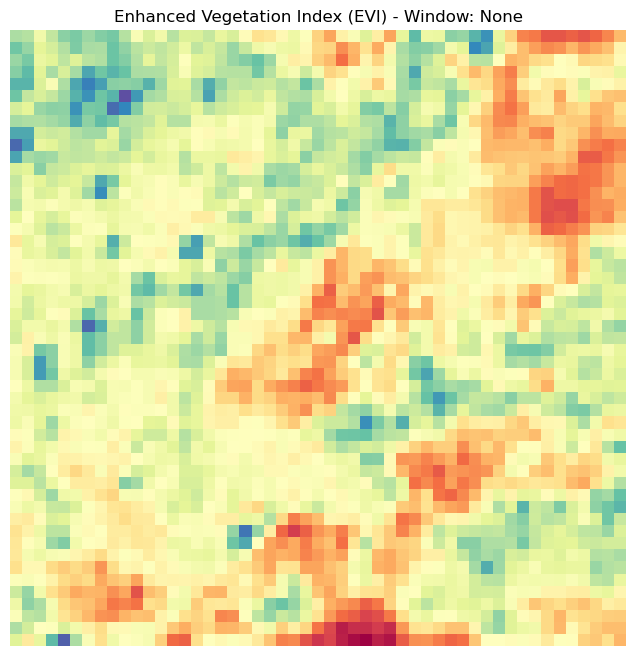

In [75]:

# Plot Enhanced Vegetation Index (EVI)
# cmap: 'coolwarm', 'PiYG', 'viridis', 'Spectral'
plot_evi(train_tiffs[min_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

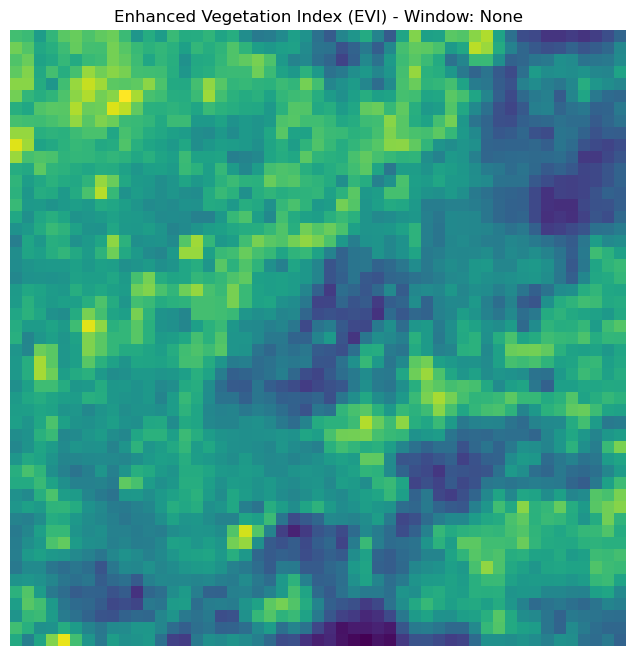

In [76]:

plot_evi(train_tiffs[min_train_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='viridis')

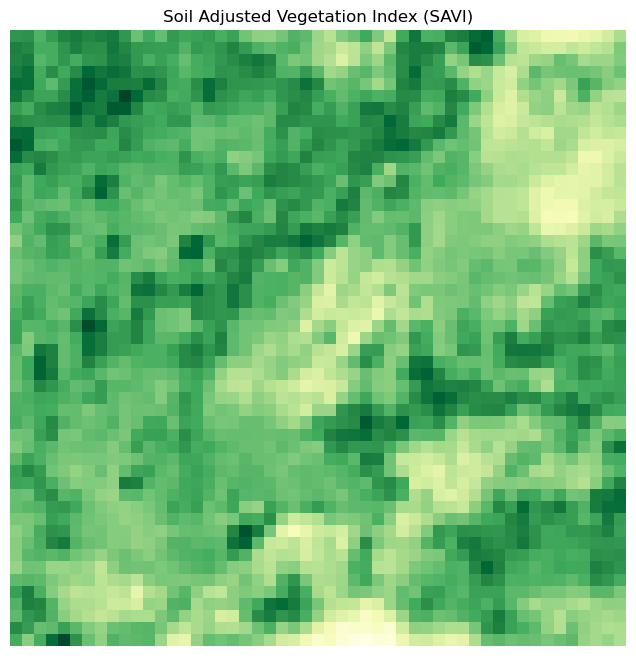

In [77]:

# Plot Soil Adjusted Vegetation Index (SAVI)
# cmap 'Greens', 'YlGnBu', 'YlGn'
plot_savi(train_tiffs[min_train_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

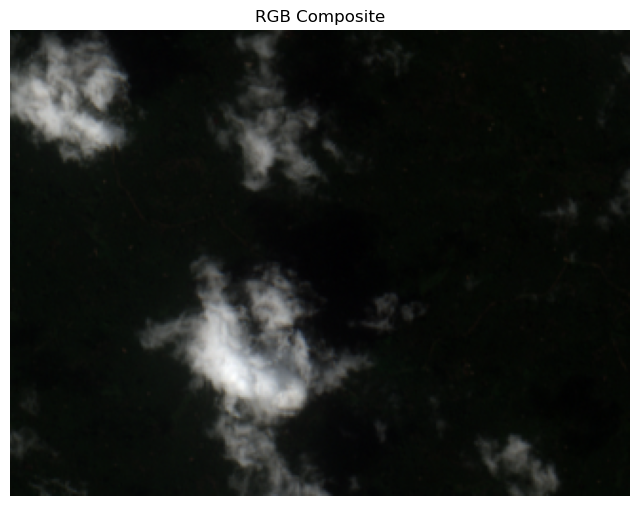

In [78]:

## Plot RGB image (Red: band 3, Green: band 2, Blue: band 1)
plot_rgb_window(test_tiffs[max_test_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

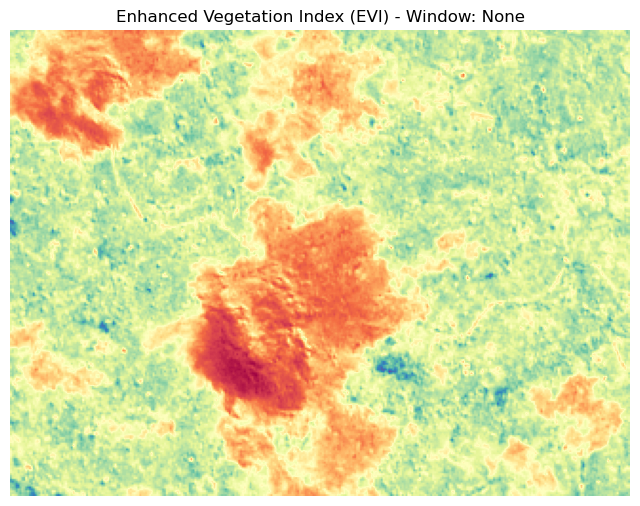

In [79]:

plot_evi(test_tiffs[max_test_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

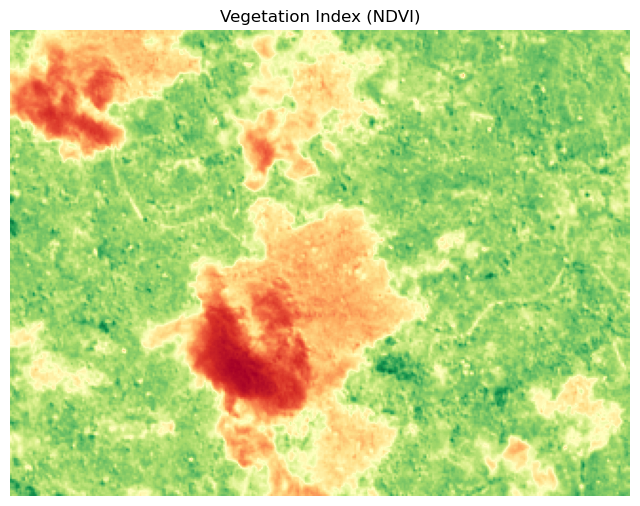

In [80]:

plot_vegetation_index(test_tiffs[max_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

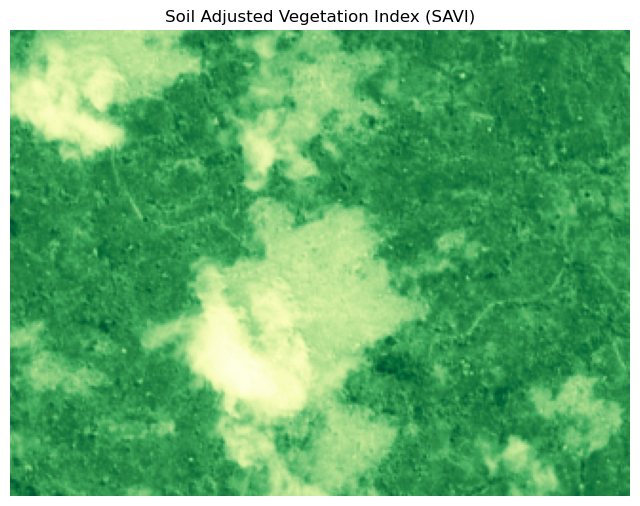

In [81]:

plot_savi(test_tiffs[max_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

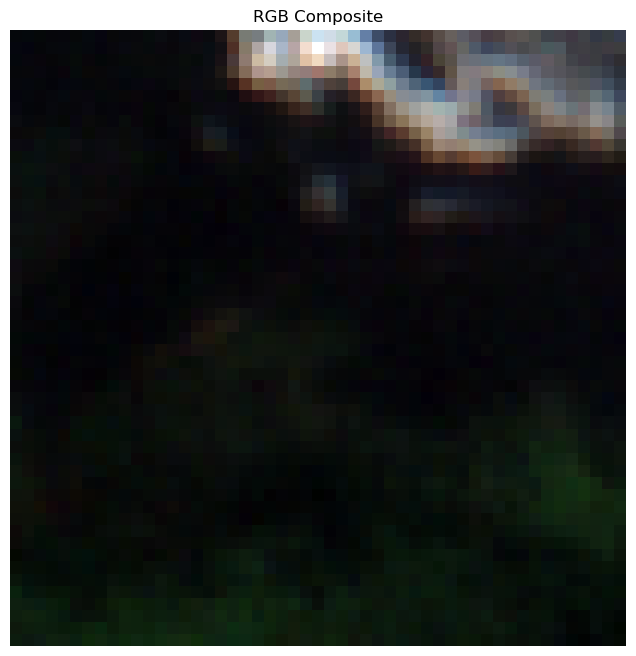

In [82]:

## Plot RGB image (Red: band 3, Green: band 2, Blue: band 1)
plot_rgb_window(test_tiffs[min_test_idx], window, r_band_idx=3, g_band_idx=2, b_band_idx=1)

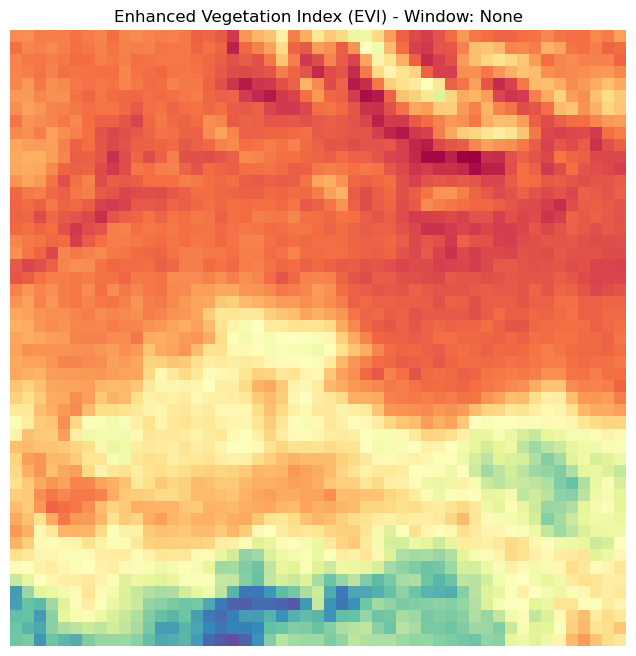

In [83]:

plot_evi(test_tiffs[min_test_idx], window, red_band_idx=3, blue_band_idx=1, nir_band_idx=7, cmap='Spectral')

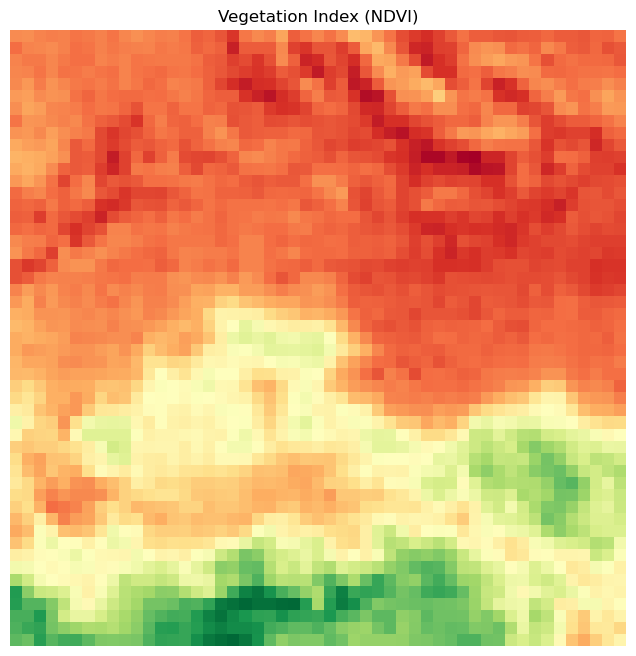

In [84]:

plot_vegetation_index(test_tiffs[min_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='RdYlGn')

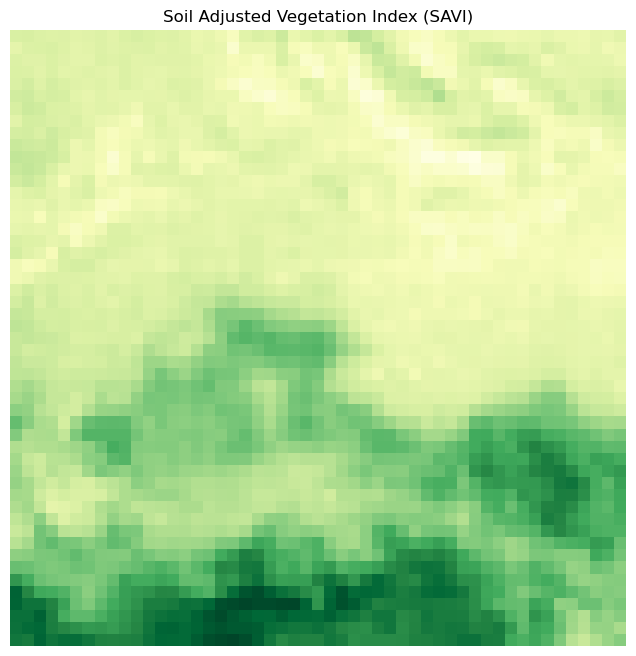

In [85]:

plot_savi(test_tiffs[min_test_idx], window, red_band_idx=3, nir_band_idx=7, cmap='YlGn')

## Pipeline for Crop Classification

These functions are used for building a basic machine learning model and displaying the target distribution.

In [94]:

# hyperparameters
TILE_SIZE = MIN_TILE_SIZE # desired size of tiles e.g. 51x51
BATCH_SIZE = 8            # batch size
EPOCHS = 100              # number of epochs to train on
LR = 5e-4                 # learning rate
WEIGHT_DECAY = 1e-4       # weight decay
DROPOUT = 0.3             # dropout in the classifier
MONTH = None              # month to train/test on (if None, all months)

# helper maps
label_map = {'Cocoa': 0, 'Palm': 1, 'Rubber': 2}
reverse_label_map = {0: 'Cocoa', 1: 'Palm', 2: 'Rubber'}

In [95]:

import os
import rasterio
import numpy as np
import pandas as pd
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score

def extract_ndvi(nir_band, red_band, epsilon=1e-8):
    """ Calculate NDVI from NIR and Red bands """
    return (nir_band - red_band) / (nir_band + red_band + epsilon)

def extract_savi(nir_band, red_band, L=0.5):
    """ Calculate SAVI from NIR and Red bands """
    return ((nir_band - red_band) * (1 + L)) / (nir_band + red_band + L)

def extract_evi(nir_band, red_band, blue_band, G=2.5, C1=6, C2=7.5, L=10000):
    """ Calculate EVI from NIR, Red, and Blue bands """
    denom = nir_band + C1 * red_band - C2 * blue_band + L

    # Avoid division by zero
    denom = np.where(denom == 0, 1e-5, denom)

    evi = G * ((nir_band - red_band) / denom)
    return evi

def center_crop_tensor(tensor, size=(TILE_SIZE, TILE_SIZE)):
    _, h, w = tensor.shape
    crop_h, crop_w = size
    start_h = (h - crop_h) // 2
    start_w = (w - crop_w) // 2
    return tensor[:, start_h:start_h + crop_h, start_w:start_w + crop_w]

def process_and_return_tiles(df, is_train=True, tile_size=TILE_SIZE):
    all_tiles = []
    all_labels = []

    for _, row in df.iterrows():
        tile_path = row['tifPath']

        if is_train:
            label_value = row['Target']
        else:
            label_value = None

        if pd.notna(tile_path) and os.path.exists(tile_path):
            try:
                with rasterio.open(tile_path) as src:
                    raster = src.read()  # (bands, height, width)

                tensor = torch.tensor(raster, dtype=torch.float32)
                cropped = center_crop_tensor(tensor, size=(tile_size, tile_size))
                all_tiles.append(cropped)

                if is_train:
                    all_labels.append(label_value)  # Append as a single list, not extend

            except Exception as e:
                print(f"⚠️ Failed to process {tile_path}: {e}")
                continue

    all_tiles_array = np.stack(all_tiles)  # shape: (N, C, H, W)
    all_labels_array = np.array(all_labels) if is_train else None  # shape: (N, 3)

    all_labels_array = np.array(all_labels_array).flatten()
    return all_tiles_array, all_labels_array

def extract_features_from_tiles(tiles):
    """Extract important features (red_edge_1, nir, swir, ndvi, savi, evi) for each tile"""
    features = []

    for tile in tiles:
        blue = tile[1]
        red = tile[3]
        red_edge_1 = tile[4]
        nir = tile[7]
        swir = tile[10]

        # Compute indices
        ndvi = extract_ndvi(nir, red)
        savi = extract_savi(nir, red)
        evi = extract_evi(nir, red, blue)

        # Feature vector
        feature_vector = [red_edge_1, nir, swir, ndvi, savi, evi]

        features.append(feature_vector)

    feature_tiles = np.stack(features)

    return feature_tiles

In [96]:

from torch.utils.data import Dataset

class SentinelCropDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return (self.features[idx], self.labels[idx])
        return self.features[idx]

In [97]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_GRU_Model(nn.Module):
    def __init__(self, in_channels=6, num_classes=3, hidden_size=128, dropout=0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.gru = nn.GRU(input_size=128, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, h*w, c)
        output, _ = self.gru(x)
        out = output[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [109]:

import torch
import torch.nn as nn
import torch.nn.functional as F

def train_model(
    model,
    train_loader,
    val_loader=None,
    epochs=100,
    lr=5e-4,
    weight_decay=1e-4,
    dropout=0.3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_classes=3,
    patience=5,
    factor=0.5
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Scheduler: Reduce LR when validation loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=patience, factor=factor
    )

    # Calculate class weights for imbalanced data
    label_list = []
    for _, y in train_loader:
        label_list.extend(y.numpy())
    class_counts = torch.bincount(torch.tensor(label_list), minlength=num_classes).float()
    weights = 1.0 / (class_counts + 1e-6)
    weights = weights / weights.sum()
    class_weights = weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    metrics = {
        'Loss': [],
        'Train Accuracy': [],
        'Validation Accuracy': {
            'Rubber': [],
            'Palm': [],
            'Cocoa': [],
            'Total': []
        },
        'Val Loss': []
    }

    reverse_label_map = {0: 'Cocoa', 1: 'Palm', 2: 'Rubber'}

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device).long()
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(dim=1) == y).sum().item()

        train_acc = correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"\nEpoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {train_acc:.2%}")
        metrics['Loss'].append(avg_loss)
        metrics['Train Accuracy'].append(train_acc)

        val_loss = None
        if val_loader:
            model.eval()
            val_correct = 0
            class_correct = torch.zeros(num_classes)
            class_total = torch.zeros(num_classes)
            total_val_loss = 0

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device).long()
                    out = model(x_val)
                    loss = criterion(out, y_val)
                    total_val_loss += loss.item() * x_val.size(0)
                    preds = out.argmax(dim=1)
                    val_correct += (preds == y_val).sum().item()
                    for i in range(num_classes):
                        class_correct[i] += ((preds == i) & (y_val == i)).sum().item()
                        class_total[i] += (y_val == i).sum().item()

            val_acc = val_correct / len(val_loader.dataset)
            avg_val_loss = total_val_loss / len(val_loader.dataset)
            print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.2%}")
            metrics['Validation Accuracy']['Total'].append(val_acc)
            metrics['Val Loss'].append(avg_val_loss)

            # Show per-class stats
            for i in range(num_classes):
                class_label = reverse_label_map[i]
                if class_total[i] > 0:
                    acc_i = class_correct[i] / class_total[i]
                    print(f"{i}. {class_label} Accuracy: {acc_i:.2%} ({int(class_correct[i])}/{int(class_total[i])})")
                    metrics['Validation Accuracy'][class_label].append(acc_i)
                else:
                    print(f"{i}. {class_label} Accuracy: N/A (no samples)")
                    metrics['Validation Accuracy'][class_label].append(0.0)

            # Step the scheduler with validation loss
            scheduler.step(avg_val_loss)
        else:
            # If no validation, step with training loss (not recommended)
            scheduler.step(avg_loss)

    return metrics

def test_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds = []

    with torch.no_grad():
        for x_test in test_loader:
            # Handle batched input
            x_test = x_test.to(device)
            outputs = model(x_test)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())

    print(f"Inference complete on {len(all_preds)} samples.")
    return all_preds


def plot_class_distribution(y):
    """Plot distribution of crop types from string class names with custom color mapping."""

    # Flatten the nested list/array
    y_flat = np.array(y).flatten()

    # Map crop names to numeric values
    class_map = {'Cocoa': 1, 'Palm': 2, 'Rubber': 3}
    reverse_map = {1: 'Cocoa', 2: 'Palm', 3: 'Rubber'}
    color_map = {'Cocoa': 'brown', 'Palm': 'green', 'Rubber': 'darkgray'}

    # Convert class names to numeric labels
    y_numeric = [class_map.get(label) for label in y_flat if label in class_map]

    # Convert back to names for counting and plotting
    y_named = [reverse_map[label] for label in y_numeric]

    # Create distribution dataframe
    crop_distribution = pd.Series(y_named).value_counts().reset_index()
    crop_distribution.columns = ['Target', 'Count']

    # Plot using Plotly
    fig = px.bar(
        crop_distribution,
        x='Target',
        y='Count',
        title="Crop Distribution",
        color='Target',
        color_discrete_map=color_map
    )

    fig.show()


In [99]:

from sklearn.model_selection import train_test_split

# train 
if MONTH is not None:
    train = train[train['month'] == MONTH]
    test = test[test['month'] == MONTH]

# crop training data into 51x51 centered tiles
tiles_array, labels = process_and_return_tiles(train)

# extract the important features
feature_tiles = extract_features_from_tiles(tiles_array)

# split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(feature_tiles, labels, test_size=0.2, stratify=labels)
print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of y_train is: {y_train.shape}")
print(f"The shape of X_val is: {X_val.shape}")
print(f"The shape of y_val is: {y_val.shape}")


The shape of X_train is: (5946, 6, 51, 51)
The shape of y_train is: (5946,)
The shape of X_val is: (1487, 6, 51, 51)
The shape of y_val is: (1487,)


In [100]:

# Show the distribution of the Target (class)
plot_class_distribution(labels)

In [104]:

from torch.utils.data import DataLoader

# Only map if labels are strings
if isinstance(y_train[0], str):
    y_train = np.array([label_map[label] for label in y_train])
    y_val = np.array([label_map[label] for label in y_val])
# If already integers, do nothing

# setup the DataLoaders
train_dataset = SentinelCropDataset(X_train, y_train)
val_dataset = SentinelCropDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# initialize and train the model
model = CNN_GRU_Model(in_channels=6, num_classes=3, hidden_size=64, dropout=DROPOUT)
metrics = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY)


Epoch 1: Loss = 1.0497, Accuracy = 42.36%
Validation Loss: 1.0822 | Validation Accuracy: 47.95%
0. Cocoa Accuracy: 23.28% (88/378)
1. Palm Accuracy: 13.94% (69/495)
2. Rubber Accuracy: 90.55% (556/614)

Epoch 2: Loss = 0.9657, Accuracy = 49.39%
Validation Loss: 0.8227 | Validation Accuracy: 60.73%
0. Cocoa Accuracy: 80.69% (305/378)
1. Palm Accuracy: 38.59% (191/495)
2. Rubber Accuracy: 66.29% (407/614)

Epoch 3: Loss = 0.9207, Accuracy = 54.76%
Validation Loss: 1.2462 | Validation Accuracy: 41.29%
0. Cocoa Accuracy: 0.00% (0/378)
1. Palm Accuracy: 0.00% (0/495)
2. Rubber Accuracy: 100.00% (614/614)

Epoch 4: Loss = 0.8897, Accuracy = 56.42%
Validation Loss: 0.8707 | Validation Accuracy: 59.38%
0. Cocoa Accuracy: 54.50% (206/378)
1. Palm Accuracy: 49.70% (246/495)
2. Rubber Accuracy: 70.20% (431/614)

Epoch 5: Loss = 0.8584, Accuracy = 58.69%
Validation Loss: 0.7901 | Validation Accuracy: 65.43%
0. Cocoa Accuracy: 61.90% (234/378)
1. Palm Accuracy: 61.41% (304/495)
2. Rubber Accuracy:

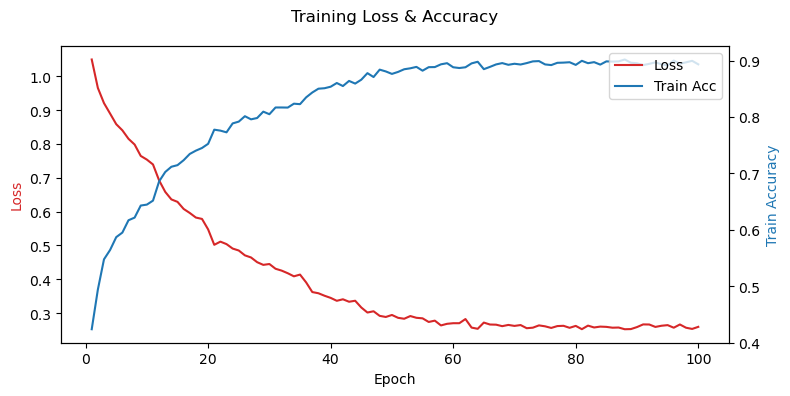

In [105]:

import matplotlib.pyplot as plt

# Number of epochs
epochs = list(range(1, len(metrics['Loss']) + 1))

fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Loss on left y‐axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, metrics['Loss'], color=color, label='Loss')
ax1.tick_params(axis='y')

# Plot Train Accuracy on right y‐axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Train Accuracy', color=color)
ax2.plot(epochs, metrics['Train Accuracy'], color=color, label='Train Acc')
ax2.tick_params(axis='y')

# Title and legend
fig.suptitle('Training Loss & Accuracy')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

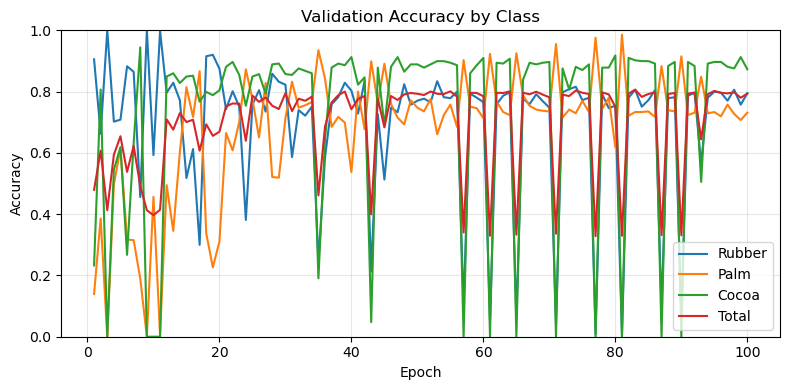

In [106]:

plt.figure(figsize=(8, 4))

for cls in ['Rubber', 'Palm', 'Cocoa', 'Total']:
    plt.plot(epochs,
             metrics['Validation Accuracy'][cls],
             label=cls)

plt.title('Validation Accuracy by Class')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

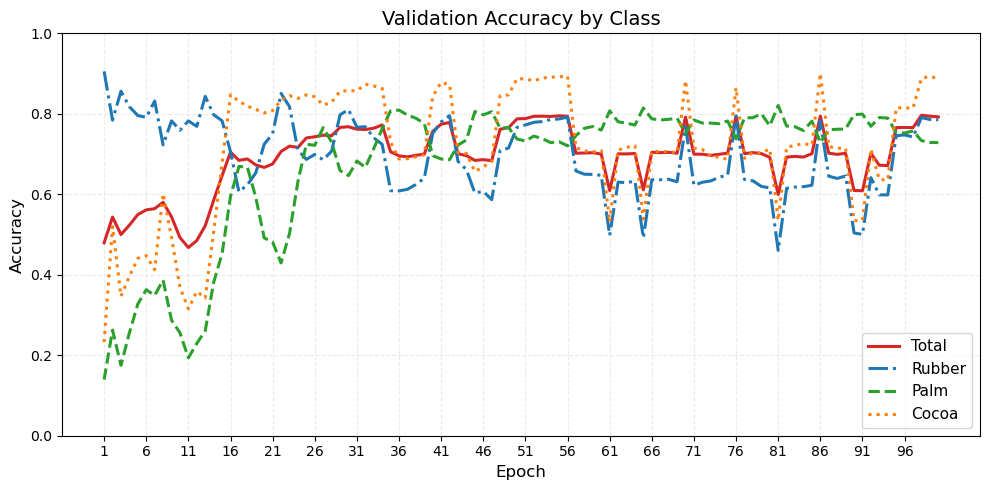

In [107]:

val_df = pd.DataFrame(metrics['Validation Accuracy'])

# rolling average window
val_smooth = val_df.rolling(window=5, min_periods=1).mean()

# Plot
plt.figure(figsize=(10, 5))
styles = {'Total':  ('-', 'tab:red'),
          'Rubber': ('-.', 'tab:blue'),
          'Palm':   ('--', 'tab:green'),
          'Cocoa':  (':', 'tab:orange')}

for cls, (linestyle, color) in styles.items():
    plt.plot(epochs,
             val_smooth[cls],
             linestyle=linestyle,
             color=color,
             linewidth=2.2,
             label=cls)

plt.title('Validation Accuracy by Class', fontsize=14)
plt.xlabel('Epoch', fontsize=12, )
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='lower right', fontsize=11)
plt.xticks(np.arange(1, len(epochs) + 1, 5))
plt.tight_layout()
plt.show()

In [110]:

# setup the test data
test_tiles_array, _ = process_and_return_tiles(test, is_train=False)
X_test = extract_features_from_tiles(test_tiles_array)
test_dataset = SentinelCropDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# test the model
test_preds = test_model(model, test_loader)

# print guesses
named_preds = [reverse_label_map[p] for p in test_preds]
print(named_preds[:10])

Inference complete on 2201 samples.
['Rubber', 'Rubber', 'Rubber', 'Rubber', 'Rubber', 'Rubber', 'Rubber', 'Rubber', 'Rubber', 'Rubber']


In [111]:

plot_class_distribution(named_preds) ## Distribution of predictions

In [112]:

## Prep submission file
print(len(test['ID']))
ss = pd.DataFrame({'ID': test['ID'], 'Target': named_preds})
ss.head()

2201


ID  Target
0  ID_731818_Jan  Rubber
1  ID_790093_Jan  Rubber
2  ID_931033_Jan  Rubber
3  ID_079024_Jan  Rubber
4  ID_691532_Jan  Rubber

In [113]:

## Write submission file
ss.to_csv('submission.csv', index=False)